# RBF Networks with Iris Data


Review from Monday:

Training a RBF consists of:
* Finding prototypes
* Selecting the activation function for the hidden nodes
* Selecting the activation function for the output nodes
* Setting the weights for the edges and biases

## Load the Data

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def typeConverter(x):
    values = ['setosa', 'versicolor', 'virginica']
    return float(values.index(x))


columns = ["sepal_length", "sepal_width", "petal_length", "petal_width", "class"]
iris = np.array(np.genfromtxt('data/iris.csv', delimiter=',', converters={4: typeConverter}, skip_header=2, dtype=float, encoding='utf-8'))  
print(iris)

[[5.1 3.5 1.4 0.2 0. ]
 [4.9 3.  1.4 0.2 0. ]
 [4.7 3.2 1.3 0.2 0. ]
 [4.6 3.1 1.5 0.2 0. ]
 [5.  3.6 1.4 0.2 0. ]
 [5.4 3.9 1.7 0.4 0. ]
 [4.6 3.4 1.4 0.3 0. ]
 [5.  3.4 1.5 0.2 0. ]
 [4.4 2.9 1.4 0.2 0. ]
 [4.9 3.1 1.5 0.1 0. ]
 [5.4 3.7 1.5 0.2 0. ]
 [4.8 3.4 1.6 0.2 0. ]
 [4.8 3.  1.4 0.1 0. ]
 [4.3 3.  1.1 0.1 0. ]
 [5.8 4.  1.2 0.2 0. ]
 [5.7 4.4 1.5 0.4 0. ]
 [5.4 3.9 1.3 0.4 0. ]
 [5.1 3.5 1.4 0.3 0. ]
 [5.7 3.8 1.7 0.3 0. ]
 [5.1 3.8 1.5 0.3 0. ]
 [5.4 3.4 1.7 0.2 0. ]
 [5.1 3.7 1.5 0.4 0. ]
 [4.6 3.6 1.  0.2 0. ]
 [5.1 3.3 1.7 0.5 0. ]
 [4.8 3.4 1.9 0.2 0. ]
 [5.  3.  1.6 0.2 0. ]
 [5.  3.4 1.6 0.4 0. ]
 [5.2 3.5 1.5 0.2 0. ]
 [5.2 3.4 1.4 0.2 0. ]
 [4.7 3.2 1.6 0.2 0. ]
 [4.8 3.1 1.6 0.2 0. ]
 [5.4 3.4 1.5 0.4 0. ]
 [5.2 4.1 1.5 0.1 0. ]
 [5.5 4.2 1.4 0.2 0. ]
 [4.9 3.1 1.5 0.2 0. ]
 [5.  3.2 1.2 0.2 0. ]
 [5.5 3.5 1.3 0.2 0. ]
 [4.9 3.6 1.4 0.1 0. ]
 [4.4 3.  1.3 0.2 0. ]
 [5.1 3.4 1.5 0.2 0. ]
 [5.  3.5 1.3 0.3 0. ]
 [4.5 2.3 1.3 0.3 0. ]
 [4.4 3.2 1.3 0.2 0. ]
 [5.  3.5 1

# Look at the Data

          0         1         2         3         4
0  7.900000  4.400000  6.900000  2.500000  2.000000
1  4.300000  2.000000  1.000000  0.100000  0.000000
2  5.843333  3.057333  3.758000  1.199333  1.000000
3  0.681122  0.188713  3.095503  0.577133  0.666667


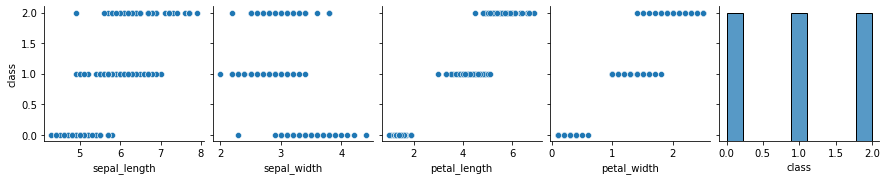

In [23]:
def getSummaryStatistics(data):
    "Get the max, min, mean, var for each variable in the data."
    return pd.DataFrame(np.array([data.max(axis=0), data.min(axis=0), data.mean(axis=0), data.var(axis=0)]))

def getShapeType(data):
    "Get the shape and type of the data."
    return (data.shape, data.dtype)

print(getSummaryStatistics(iris))
getShapeType(iris)

df = pd.DataFrame(iris, columns=columns)

sns.pairplot(df, y_vars = ["class"], kind = "scatter")

## What kind of analysis are we going to do?

Regression, clustering, classification?

If supervised, which is our dependent variable?

If we have a dependent variable, how many possible values does it have? What will this number correspond to in the RBF network?

In [24]:
# Why are we doing this?
np.random.shuffle(iris)

# Why are we doing this?
train_data, dev_data, test_data = np.split(iris, [int(.8 * len(iris)), int(.9 * len(iris))])
print("train", "\n", getSummaryStatistics(train_data), np.unique(train_data[:, -1]))
print("dev", "\n", getSummaryStatistics(dev_data), np.unique(dev_data[:, -1]))
print("test", "\n", getSummaryStatistics(test_data), np.unique(test_data[:, -1]))

train 
           0         1         2         3         4
0  7.900000  4.400000  6.900000  2.500000  2.000000
1  4.300000  2.000000  1.000000  0.100000  0.000000
2  5.822500  3.035833  3.740833  1.185833  0.983333
3  0.672244  0.178133  2.970749  0.564383  0.633056 [0. 1. 2.]
dev 
           0         1         2         3         4
0  7.700000  4.200000  6.700000  2.400000  2.000000
1  4.400000  2.200000  1.300000  0.100000  0.000000
2  5.920000  3.166667  3.753333  1.180000  1.066667
3  0.758933  0.299556  3.855822  0.622933  0.862222 [0. 1. 2.]
test 
           0         1         2         3         4
0  7.100000  3.900000  5.900000  2.500000  2.000000
1  4.400000  2.300000  1.300000  0.200000  0.000000
2  5.933333  3.120000  3.900000  1.326667  1.066667
3  0.656889  0.142933  3.310667  0.615289  0.728889 [0. 1. 2.]


In [25]:
# Let's split off the y variables

train_data, train_y = train_data[:, :-1], train_data[:, -1]
dev_data, dev_y = dev_data[:, :-1], dev_data[:, -1]
test_data, test_y = test_data[:, :-1], test_data[:, -1]

## Does the data need to be cleaned?

Are there missing or erroneous values? 

Do we need to fix the types of some of the variables?

## Does it need to be normalized?

Is the range of one or more values clearly out of line with the rest?

## Consider transformation

Would PCA help?
* if we had a thousand independent variables, probably, but in this case no

In [27]:
def homogenizeData(data):
    return np.append(data, np.array([np.ones(data.shape[0], dtype=float)]).T, axis=1)
   
def zScore(data, translateTransform=None, scaleTransform=None):
    "z score."
    homogenizedData = np.append(data, np.array([np.ones(data.shape[0], dtype=float)]).T, axis=1)
    if translateTransform is None:
        translateTransform = np.eye(homogenizedData.shape[1])
        for i in range(homogenizedData.shape[1]):
            translateTransform[i, homogenizedData.shape[1]-1] = -homogenizedData[:, i].mean()
    if scaleTransform is None:
        diagonal = [1 / homogenizedData[:, i].std() if homogenizedData[:, i].std() != 0 else 1 for i in range(homogenizedData.shape[1])]
        scaleTransform = np.eye(homogenizedData.shape[1], dtype=float) * diagonal
    data = (scaleTransform@translateTransform@homogenizedData.T).T
    return translateTransform, scaleTransform, data[:, :data.shape[1]-1]

translateTransform, scaleTransform, train_data_transformed = zScore(train_data)
print(getSummaryStatistics(train_data_transformed))
getShapeType(train_data_transformed)

              0             1             2             3
0  2.533831e+00  3.232181e+00  1.832903e+00  1.749297e+00
1 -1.856923e+00 -2.454246e+00 -1.590192e+00 -1.445361e+00
2 -1.065814e-15  1.110223e-16 -1.480297e-17  2.220446e-17
3  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00


((120, 4), dtype('float64'))

# Find Prototypes

To do this, we use kmeans. I am going to use the scikit-learn implementation; you should use your own for the project.

Why would we not just have the number of prototypes be equal to the number of classes?

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
[[  2.         127.56157509]
 [  3.          65.12021196]
 [  4.          45.84044231]
 [  5.          37.21218824]
 [  6.          31.60320652]
 [  7.          27.92866385]
 [  8.          23.86544607]
 [  9.          21.83679269]
 [ 10.          20.59343705]
 [ 11.          19.4574545 ]
 [ 12.          18.19651294]
 [ 13.          16.90310702]
 [ 14.          16.20230198]
 [ 15.          15.14039177]
 [ 16.          14.3431369 ]]


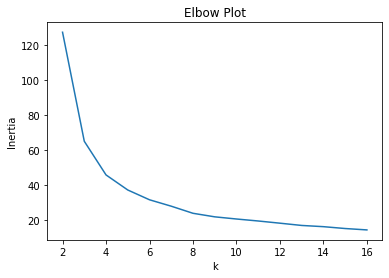

In [28]:
from sklearn.cluster import KMeans

inertia_by_k = []

for k in range(2, 17):
    print(k)
    km = KMeans(n_clusters=k, random_state=0).fit(train_data)
    inertia_by_k.append([k, km.inertia_])

inertia_by_k = np.array(inertia_by_k)
print(inertia_by_k)
fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(111)
ax1.plot(inertia_by_k[:, 0], inertia_by_k[:, 1])
ax1.set_xlabel('k')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Plot')
plt.show()

So, what value will we choose for k? What will this number correspond to in the RBF network?

In [29]:
# Let's get the centroid for each hiddent node - each prototype
k = 8

km = KMeans(n_clusters=k, random_state=0).fit(train_data)

print(km.cluster_centers_)

[[5.28947368 3.65263158 1.51578947 0.27368421]
 [6.42941176 2.94705882 4.58823529 1.42941176]
 [7.51111111 3.2        6.3        2.07777778]
 [5.24285714 2.37142857 3.44285714 1.02857143]
 [5.60526316 2.70526316 4.14210526 1.29473684]
 [4.735      3.14       1.42       0.2       ]
 [6.53529412 3.09411765 5.51764706 2.15882353]
 [6.025      2.71666667 5.03333333 1.8       ]]


# Define the Activation Function for the Hidden Nodes

Recall that a typical activation function for the hidden nodes is the Gaussian, so something like $exp \left( - \frac{||\vec{d}-\vec{\mu_j}||^2}{2\delta_j^2 + \epsilon} \right)$, where $\vec{d}$ is the data point, $\vec{\mu_j}$ is the prototype, $\delta_j$ is the hidden unit's standard deviation, $\epsilon$ is a small constant and $||.||^2$ is the squared Euclidean distance.

Let's take a good look at this activation function. 
* What is in the numerator? Why look, it's the distance! Why would we not just use the distance itself as the activation function? 
* What is the function of $\delta_j$?
* Why do we have $\epsilon$?

# What Will We Do When We Get a New Data Point?

At this point, we have defined:
* The input layer (ish)
* The hidden layer

For a new data point, we will:
1. encode it using the same zscoring we did on train - not defining a new zscoring. IE use mean and stdev from the *training data*
2. send it to each of the hidden layer nodes (so the weights from the input layer to the hidden layer are all 1)
3. each hidden layer node will calculate its activation for this data point

On Monday we will define the output layer, and explain how it relates to another analysis method we already know well, linear regression. We will then show how we can *also use RBF networks for regression*!

# Let's Process the Dev Data Through the Hidden Layer with Matrix Math

So to process a set of data points, eg the dev data, I'm going to:
1. "encode" - input layer - subtract mean of training data and divide by stdev of training data. Take a look at zScore above; it *already does all this with matrix multiplication*! Remember, a zScoring is just a translation and scaling.
2. calculate activations of hidden layer nodes. Take a look at the activation function. Inside the exponent, it has a numerator and a denominator. The denominator operates as a scaling, and you know how to do that. The numerator includes a translation (see the minus?) and then squares it (and you know how to do that!). And the exponentiation can be done via broadcasting.

Because you should implement the activation function above yourselves, I'm instead going to implement this stupid activation function just to show you the matrix math:
$exp \left( - \frac{||\vec{d}-\vec{\mu_j}||}{3} \right)$

In [30]:
# The other thing you need is for each of these, the activation function
# I am going to implement a _stupid activation function_ so that you can implement the right one yourselves for project 7
def calculateActivations(data, centroids):
    "I repeat, do not use this activation function directly. This one is exp(-distance / 3); yours is exp(-distance^2 / (2*radius + epsilon))"
    # You can easily fiddle with this numerator to make it calculate the square of the distance
    numerator = -np.linalg.norm(data-centroids[:,np.newaxis], axis = 2).T
    # The construction of your denominator will be a little more complex than this; the diagonals will be centroid/prototype-specific
    denominator = np.eye(centroids.shape[0], dtype=float) * 1/3
    print(numerator.shape, denominator.shape)
    return np.exp((denominator@numerator.T).T)

# First we need to normalize the dev data using the scale and translate from the train data
dev_data_transformed = zScore(dev_data, translateTransform, scaleTransform)
print(calculateActivations(dev_data, km.cluster_centers_))

(15, 8) (8, 8)
[[0.27893144 0.8446792  0.50478036 0.5342595  0.71056442 0.26091684
  0.73638997 0.90383122]
 [0.81810221 0.28590154 0.14917312 0.3834434  0.33164966 0.64675281
  0.20156875 0.24087097]
 [0.85506033 0.31566159 0.15786708 0.47768608 0.39084709 0.81159035
  0.22271959 0.27628038]
 [0.91370789 0.29365289 0.14704766 0.44203262 0.35996871 0.84009825
  0.20476814 0.25381618]
 [0.13386683 0.42970097 0.81833824 0.24529283 0.32390868 0.1213775
  0.56874033 0.45341607]
 [0.37605812 0.79134255 0.38847522 0.68357678 0.8399012  0.35137425
  0.54494469 0.6808121 ]
 [0.23293148 0.74358912 0.58934219 0.45262276 0.60063967 0.21778289
  0.83620349 0.85465178]
 [0.20729004 0.61077947 0.61685772 0.37391233 0.50046921 0.1899557
  0.85713867 0.69160959]
 [0.84975388 0.28545445 0.14692463 0.39829934 0.3392457  0.69899184
  0.20095336 0.24341617]
 [0.28809763 0.89351936 0.53307949 0.49475167 0.64688309 0.26021721
  0.70166429 0.74168738]
 [0.26078382 0.72672684 0.46397802 0.54832479 0.6952351  